# Analysing spread-skill relationship in the data

In [70]:
import nc_time_axis, cftime, functools
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as ctp
from importlib import reload

from hyblim.data import preproc, eof 
from hyblim.utils import enso, metric, eval
import hyblim.geoplot as gpl

plt.style.use("../../paper.mplstyle")


plotpath = "../../plots/presentation/cslim_ssta-ssha/"

## Load data

In [4]:
datapaths = {}
datapaths['ssta'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssta_lat-31_33_lon130_290_gr1.0.nc"
datapaths['ssha'] = "../../data/cesm2-picontrol/b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.ssha_lat-31_33_lon130_290_gr1.0.nc"

da_arr, normalizer = [], {}
for var, path in datapaths.items():
    da = xr.open_dataset(path)[var]
    # Normalize data 
    normalizer_var = preproc.Normalizer()
    da = normalizer_var.fit_transform(da)
    # Store normalizer as an attribute in the Dataarray for the inverse transformation
    da.attrs = normalizer_var.to_dict()
    da_arr.append(da)
    normalizer[var] = normalizer_var

ds = xr.merge(da_arr)

# Apply land sea mask
lsm = xr.open_dataset("../../data/land_sea_mask_common.nc")['lsm']
ds = ds.where(lsm!=1, other=np.nan)


In [41]:

train_period = (0, int(0.8*len(ds['time'])))
val_period = (int(0.8*len(ds['time'])), int(0.9*len(ds['time'])))
test_period = (int(0.9*len(ds['time'])), len(ds['time']))


In [6]:
nino_indices = enso.get_nino_indices(ds['ssta'])

# Windows of oportunities in data

In [82]:
(nino34['time'].dt.month.values == 1)

array([False, False, False, ..., False, False,  True])

In [122]:
def nino_trajectories(nino34, percentile, max_lag=24):
    """ Returns the evolution of the Nino3.4 index for each event in the given percentile range."""
    idx_init_times = np.argwhere(
        (nino34.values > np.percentile(nino34.values, percentile[0])) &
        (nino34.values < np.percentile(nino34.values, percentile[1])) &
        (nino34['time'].dt.month.values == 1)
    ).flatten()
    init_times = nino34['time'].values[idx_init_times]

    nino34_evolution = [] 
    for idx in idx_init_times[:-2]:
        evolution = nino34.isel(time=slice(idx, idx+max_lag))
        evolution = evolution.rename({'time': 'lag'})
        evolution['lag'] = np.arange(0, max_lag)
        nino34_evolution.append(evolution)
    nino34_evolution = xr.concat(nino34_evolution, dim=pd.Index(init_times[:-2], name='init_time'))
    return nino34_evolution

nino34 = nino_indices['nino34']
percentile = [95, 100]
trajectories = nino_trajectories(nino34, percentile, max_lag=13)

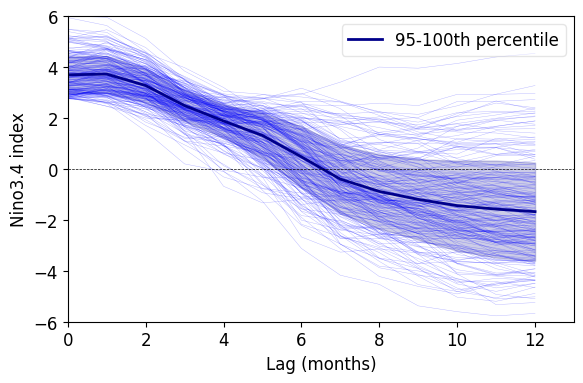

In [123]:
fig, ax = plt.subplots(figsize=(6, 4))
for init_time in trajectories['init_time']:
    ax.plot(trajectories.sel(init_time=init_time)['lag'], trajectories.sel(init_time=init_time), color='blue', linewidth=0.3, alpha=0.3)
pl = ax.plot(trajectories['lag'], trajectories.mean(dim='init_time'), color='darkblue', linewidth=2, label=f"{percentile[0]}-{percentile[1]}th percentile")
ax.fill_between(trajectories['lag'], trajectories.mean(dim='init_time')-trajectories.std(dim='init_time'), trajectories.mean(dim='init_time')+trajectories.std(dim='init_time'),
                color=pl[0].get_color(), alpha=0.2)

ax.set_ylim(-6, 6)
ax.set_xlim(0, 13)
ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
ax.set_xlabel("Lag (months)")
ax.set_ylabel("Nino3.4 index")
ax.legend(loc=1)
